In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [3]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [4]:
from MNM_nb import *
import MNMAPI
from sDODE import *

In [5]:
data_folder = os.path.join('..', '..', '..', 'data', 'input_files_7link_fix')

In [6]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)

MNM_config
MNM_pathtable


In [7]:
nb.link_list

[MNM_dlink, ID: 1, type: PQ, length: 1.0 miles, ffs: 99999.0 mi/h,
 MNM_dlink, ID: 2, type: CTM, length: 0.15 miles, ffs: 45.0 mi/h,
 MNM_dlink, ID: 3, type: CTM, length: 0.15 miles, ffs: 45.0 mi/h,
 MNM_dlink, ID: 4, type: CTM, length: 0.15 miles, ffs: 45.0 mi/h,
 MNM_dlink, ID: 5, type: CTM, length: 0.15 miles, ffs: 45.0 mi/h,
 MNM_dlink, ID: 6, type: CTM, length: 0.15 miles, ffs: 45.0 mi/h,
 MNM_dlink, ID: 7, type: PQ, length: 1.0 miles, ffs: 99999.0 mi/h]

In [8]:
config = dict()
config['use_link_flow'] = True
config['use_link_tt'] = False
config['link_flow_weight'] = 1
config['link_tt_weight'] = 1
config['num_data'] = 100
config['observed_links'] = [3, 5]
config['paths_list'] = [0, 1, 2]

In [9]:
num_interval = nb.config.config_dict['DTA']['max_interval']
theta = 0.01

In [10]:
sdode = SDODE(nb, config)
true_q = sdode.init_demand_flow(init_scale = 100)
old_f = np.zeros(num_interval * len(config['paths_list']))
num_iters = 100
P = sdode.nb.get_route_portion_matrix()
true_f = P.dot(true_q)
for i in range(num_iters):
    dta = sdode._run_simulation(true_f)
    path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))
    sdode.assign_route_portions(path_cost, theta = theta)
    new_f = sdode.nb.get_route_portion_matrix().dot(true_q)
    true_f = np.float(i) / np.float(i+1) * true_f + np.float(1) / np.float(i+1) * new_f
#     print np.linalg.norm(true_f - old_f)
    old_f = true_f
    sdode.nb.update_demand_path(new_f)

In [11]:
assert (np.isclose(true_q.sum(), true_f.sum()))

In [12]:
true_f.sum()

505.7516939009564

In [13]:
dta = sdode._run_simulation(true_f)
true_P = sdode.nb.get_route_portion_matrix()
true_full_dar = sdode.get_full_dar(dta, true_f)
true_dar = true_full_dar[sdode.get_full_observed_link_index(),:]
true_x = true_dar.dot(true_f)

In [14]:
sdode.get_full_observed_link_index()

[2, 4, 9, 11, 16, 18, 23, 25, 30, 32, 37, 39, 44, 46, 51, 53, 58, 60, 65, 67]

In [15]:
true_full_dar.shape

(70, 30)

In [16]:
true_x

array([35.8, 21. , 13.3, 28. , 30.1, 26.1,  5.1, 26. , 34. , 26.1, 10.6,
       26. ,  3.1, 26. ,  0.7, 26. , 25.2, 26. , 21.4, 26. ])

In [17]:
num_data = 10
data_dict = dict()
data_dict['link_flow'] = list()
for i in range(config['num_data']):
    link_df = pd.DataFrame(index = range(num_interval), columns = config['observed_links'], 
                           data = true_x.reshape((num_interval, len(config['observed_links']))) 
                               + np.random.randn(num_interval, len(config['observed_links'])) / 5)
    data_dict['link_flow'].append(link_df)

In [18]:
sdode.add_data(data_dict)

In [19]:
q_e = sdode.estimate_demand(step_size = 0.1, theta = theta, max_epoch = 60)

Epoch: 0 Loss: 104.72284572844418
Epoch: 1 Loss: 100.91999355632419
Epoch: 2 Loss: 97.08980399880265
Epoch: 3 Loss: 93.26593613333094
Epoch: 4 Loss: 89.30016608392047
Epoch: 5 Loss: 85.5714626288112
Epoch: 6 Loss: 81.83653296545016
Epoch: 7 Loss: 78.1108241968874
Epoch: 8 Loss: 74.36936251462012
Epoch: 9 Loss: 70.36093974244957
Epoch: 10 Loss: 66.77107096780975
Epoch: 11 Loss: 63.27494794405048
Epoch: 12 Loss: 60.020936662232586
Epoch: 13 Loss: 57.08668127399245
Epoch: 14 Loss: 54.1645161215747
Epoch: 15 Loss: 51.17951757614107
Epoch: 16 Loss: 48.51898317707205
Epoch: 17 Loss: 46.369795283645
Epoch: 18 Loss: 44.66170412226597
Epoch: 19 Loss: 42.91773897062473
Epoch: 20 Loss: 41.549301255066524
Epoch: 21 Loss: 40.32797345036965
Epoch: 22 Loss: 39.12271444670548
Epoch: 23 Loss: 37.78654638797843
Epoch: 24 Loss: 36.2825110715346
Epoch: 25 Loss: 35.123162465058655
Epoch: 26 Loss: 33.79043593744456
Epoch: 27 Loss: 32.123100987103946
Epoch: 28 Loss: 30.475329795691497
Epoch: 29 Loss: 28.8361

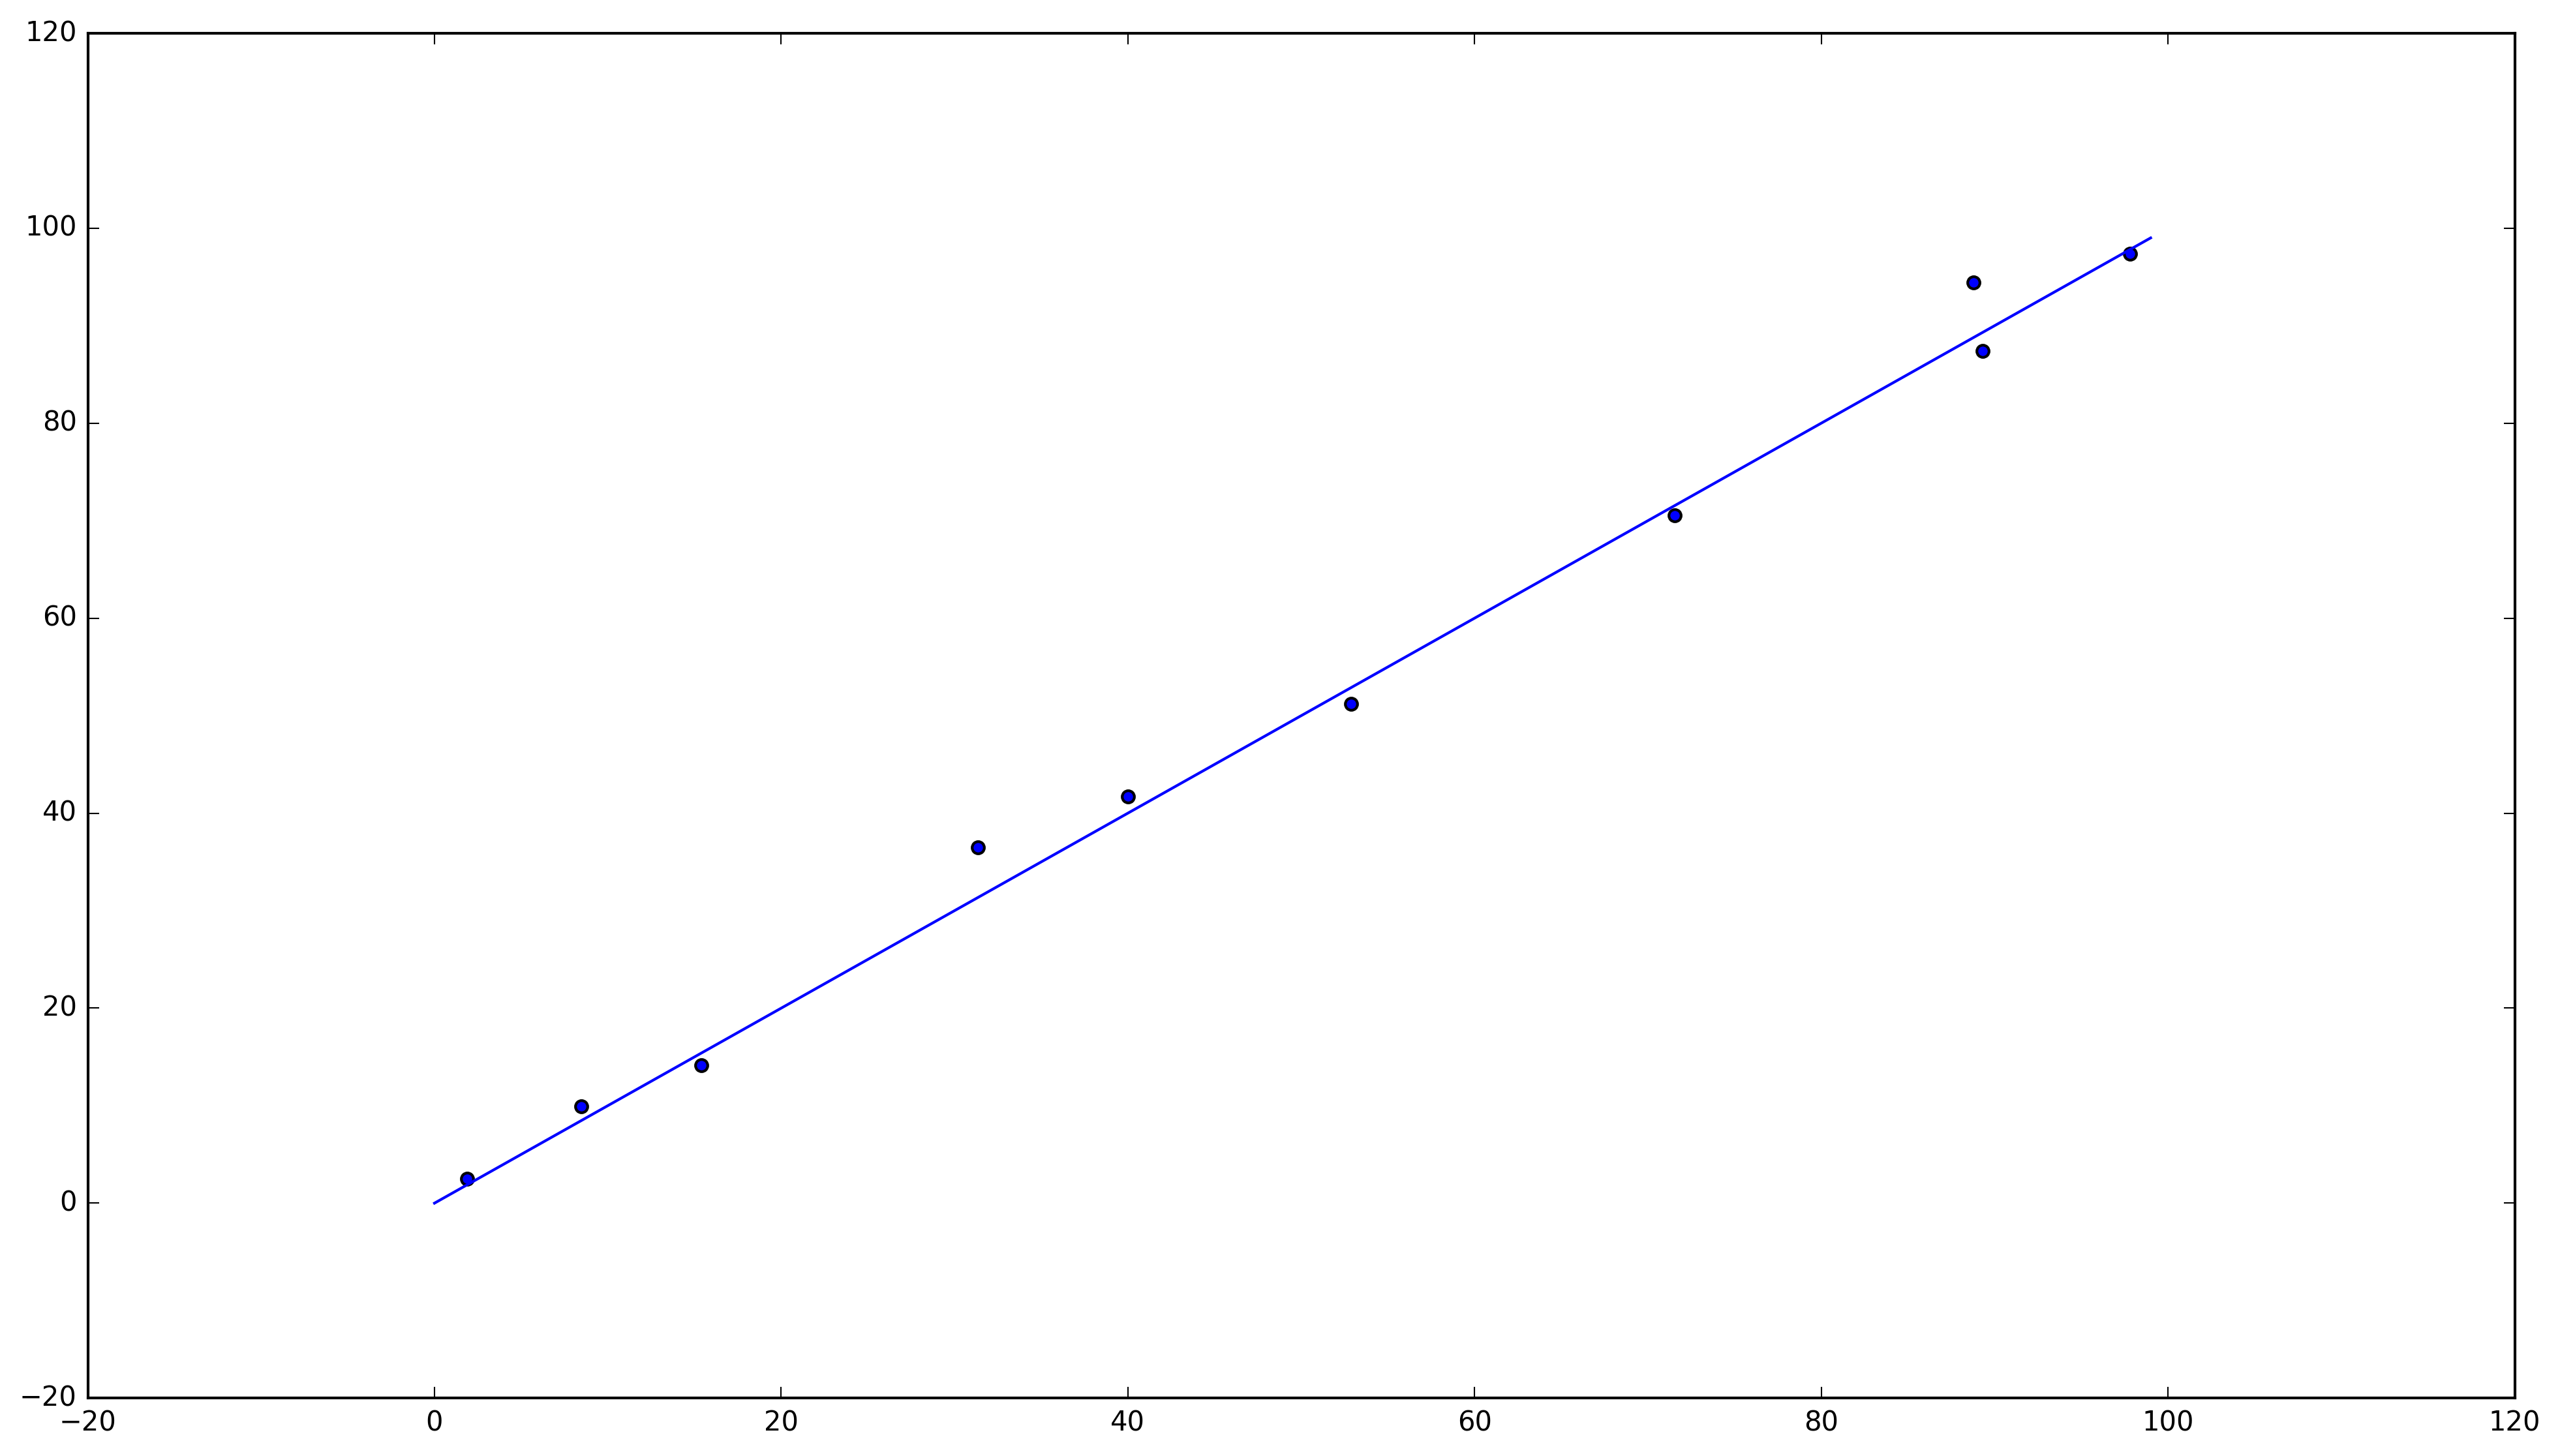

In [20]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(q_e, true_q)
plt.plot(range(100), range(100))
plt.show()

In [21]:
e_P = sdode.nb.get_route_portion_matrix()
e_f = e_P.dot(q_e)
e_full_dar = sdode.get_full_dar(dta, e_f)
e_dar = true_full_dar[sdode.get_full_observed_link_index(),:]
e_x = e_dar.dot(e_f)

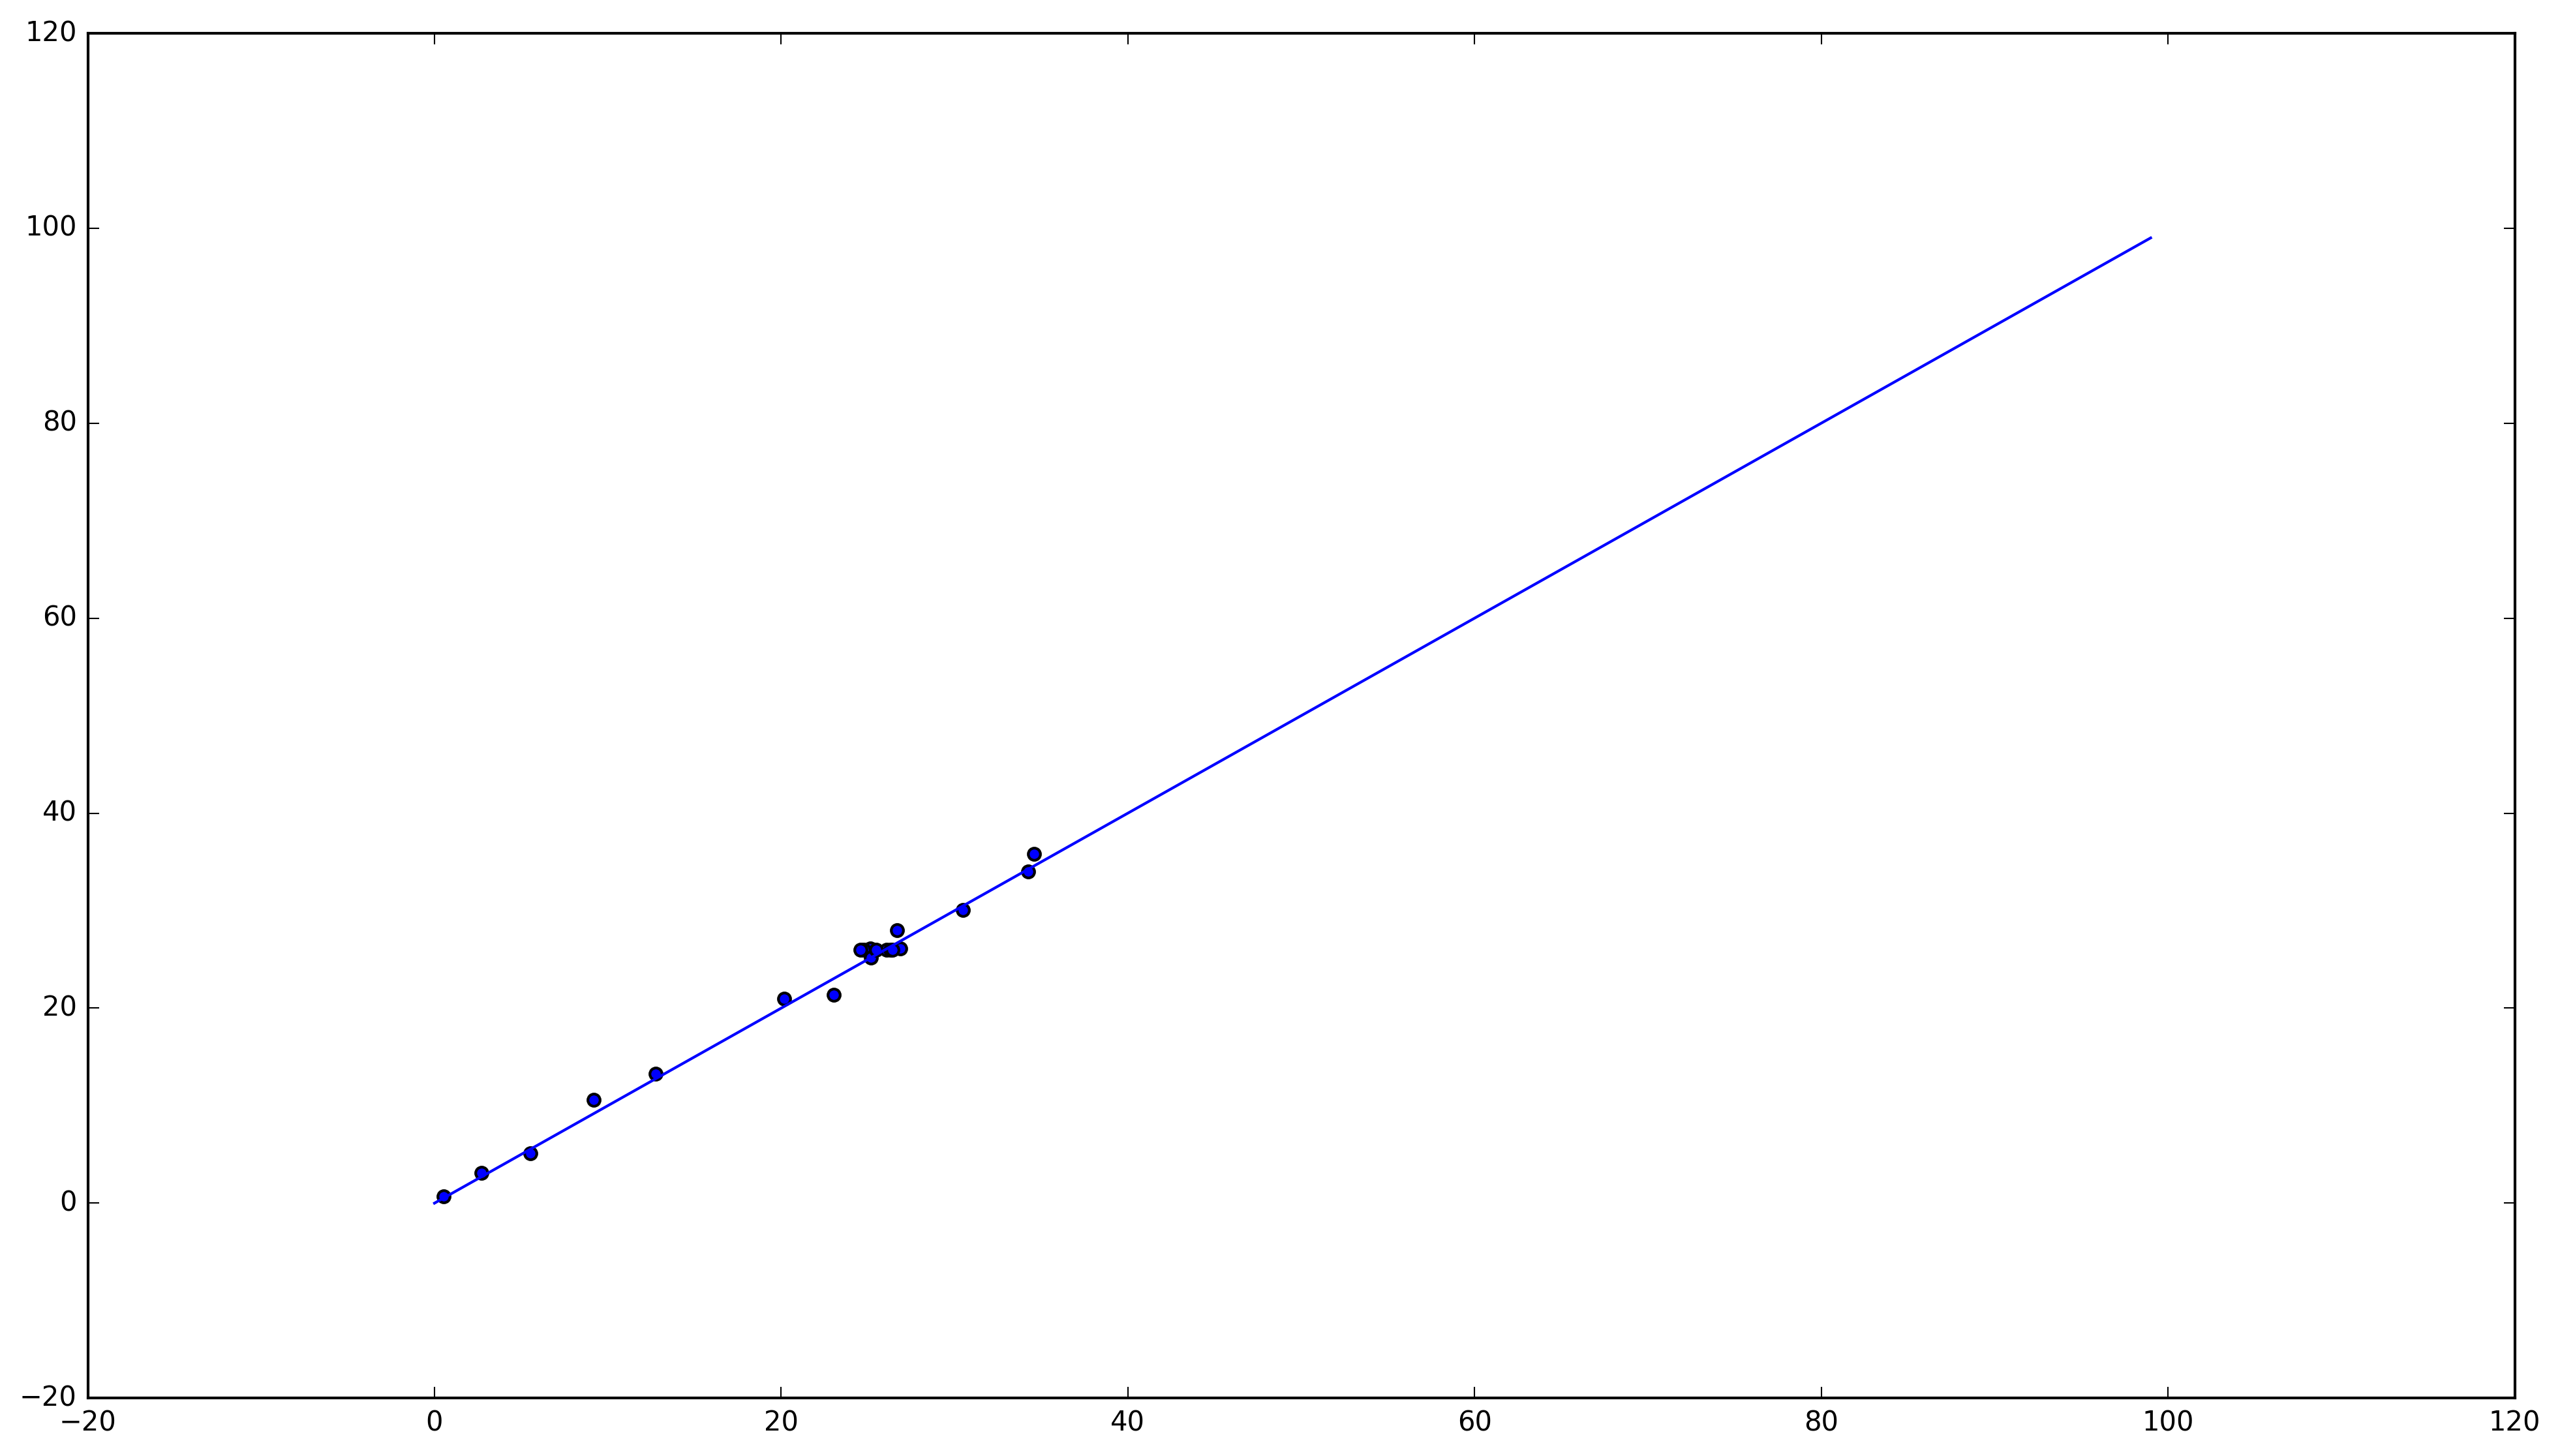

In [22]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(e_x, true_x)
plt.plot(range(100), range(100))
plt.show()

In [28]:
np.concatenate([np.random.rand(5) for i in range(5)]).shape

(25,)

In [30]:
np.maximum(np.random.rand(10), 0.5)

array([0.5       , 0.77858451, 0.87645937, 0.95343029, 0.75517769,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ])